In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

%matplotlib inline
import scrublet as scr
import scipy.io
import os

#from matplotlib import rcParams
#sc.logging.print_header()

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('default')  

sc.settings.set_figure_params(dpi=80)
#sc.logging.print_versions()


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [3]:
!pwd

/projects/banchereau-lab/USERS/nehard/SingleCell/Jupyter/Covid/pCov_2021/NoteBooks


# Read the merged rawdata counts matrix (after aggr function- cell ranger)

In [4]:
#--April 13 2021 : pCov40 = new cohort with 26 pCov + 14 pHC

adata = sc.read_10x_mtx('/projects/banchereau-lab/USERS/nehard/SingleCell/Covid19/scRNAseq/pCov_2021/pCov_2021_agg/outs/filtered_feature_bc_matrix', 
                        var_names='gene_symbols', cache=True)
adata

... writing an h5ad cache file to speedup reading next time


/home/nehard/anaconda3/envs/Hnunu/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 313076 × 33538
    var: 'gene_ids', 'feature_types'

In [5]:
adata.write('../H5AD/pCov40_raw_BS_04132021.h5ad')

/home/nehard/anaconda3/envs/Hnunu/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical


In [6]:
adata.obs.head(5)

""
AAACCCAAGAACTGAT-1
AAACCCAAGCGGGTTA-1
AAACCCAAGTGTAGAT-1
AAACCCACAACAAAGT-1
AAACCCACACGACAGA-1


# read 'raw' object wo sample information 

In [4]:
adata_raw =sc.read('../H5AD/pCov40_raw_BS_04132021.h5ad')
adata_raw

AnnData object with n_obs × n_vars = 313076 × 33538
    var: 'gene_ids', 'feature_types'

In [5]:
adata_raw.obs.head(5)

""
AAACCCAAGAACTGAT-1
AAACCCAAGCGGGTTA-1
AAACCCAAGTGTAGAT-1
AAACCCACAACAAAGT-1
AAACCCACACGACAGA-1


In [6]:
adata_raw.obs['Cells']=adata_raw.obs.index 
adata_raw

AnnData object with n_obs × n_vars = 313076 × 33538
    obs: 'Cells'
    var: 'gene_ids', 'feature_types'

In [7]:
adata_raw.obs.head()

,Cells
AAACCCAAGAACTGAT-1,AAACCCAAGAACTGAT-1
AAACCCAAGCGGGTTA-1,AAACCCAAGCGGGTTA-1
AAACCCAAGTGTAGAT-1,AAACCCAAGTGTAGAT-1
AAACCCACAACAAAGT-1,AAACCCACAACAAAGT-1
AAACCCACACGACAGA-1,AAACCCACACGACAGA-1


In [11]:
#--- save meta before scruber (BS)
adata_raw.obs.to_csv('../Meta/Meta_pCov40_BS_04132021.csv')

In [12]:
Meta = pd.read_csv('../Meta/Meta_pCov40_BS_04132021.csv')
Meta.tail(4)

,Unnamed: 0,Cells
313072,TTTGTTGAGCTGACAG-40,TTTGTTGAGCTGACAG-40
313073,TTTGTTGCAGACATCT-40,TTTGTTGCAGACATCT-40
313074,TTTGTTGGTTCCACGG-40,TTTGTTGGTTCCACGG-40
313075,TTTGTTGTCTTGGGCG-40,TTTGTTGTCTTGGGCG-40


In [8]:
Meta = adata_raw.obs

# Add sample information to the the matrix (from sample to cells)

In [9]:
#-- set R HOME 
os.environ['R_HOME'] = '/home/nehard/anaconda3/envs/loompy/lib/R'

import rpy2
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

#  petit meta = meta data per cell - Before scrublet 

In [10]:
%%R -i Meta
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))

MetaData <- read.csv('../Meta/Meta_pCov40_BS_04132021.csv', row.names=1)  #****
head(MetaData)
 

                                Cells
AAACCCAAGAACTGAT-1 AAACCCAAGAACTGAT-1
AAACCCAAGCGGGTTA-1 AAACCCAAGCGGGTTA-1
AAACCCAAGTGTAGAT-1 AAACCCAAGTGTAGAT-1
AAACCCACAACAAAGT-1 AAACCCACAACAAAGT-1
AAACCCACACGACAGA-1 AAACCCACACGACAGA-1
AAACCCAGTAGACAGC-1 AAACCCAGTAGACAGC-1


In [11]:
%%R
MetaData %>% separate(Cells,c("Cells1", "Samples"), "-") %>% dplyr::select(Samples) -> meta
tail(meta)

                    Samples
TTTGGTTTCATCGTAG-40      40
TTTGTTGAGCGTTCCG-40      40
TTTGTTGAGCTGACAG-40      40
TTTGTTGCAGACATCT-40      40
TTTGTTGGTTCCACGG-40      40
TTTGTTGTCTTGGGCG-40      40


In [12]:
!pwd

/projects/banchereau-lab/USERS/nehard/SingleCell/Jupyter/Covid/pCov_2021/NoteBooks


# grand Meta = meta per sample (.txt or .csv)

In [13]:
%%R
#---- csv file with meta data (Age, gender, batches, ...): 05-25-2019
Meta <- read.csv("../Meta/pCov40_SampleInfo_04132021.txt", sep='\t', header=T,row.names=1) #****
#Meta$Names_VacDay <- paste0(Meta$Names, '_', Meta$VacDay)

head(Meta,12)
    

                  Names Fig_ids Groups Gender Ethnicity Age_Months Year
JB19050      HPIR_021_1    pHC1    pHC      F         W       2.17 2020
JB19053      HPIR_022_1    pHC2    pHC      F         W       1.87 2020
JB19056      HPIR_023_5    pHC3    pHC      F         W      12.07 2020
JB19057      HPIR_013_9    pHC4    pHC      F        AA       8.53 2020
JB19058      HPIR_036_1    pHC5    pHC      M  Biracial       1.93 2020
JB19066      HPIR_060_1    pHC6    pHC      F        AA       1.83 2020
JB19069      HPIR_074_1    pHC7    pHC      F        AA       2.13 2020
JB20064 COVID_IN_005_V1   pCoV1   pCov      F        AA       9.50 2020
JB20065 COVID_IN_007_V1   pCoV2   pCov      F        AA       1.00 2020
JB20066 COVID_IN_031_V1   pCoV3   pCov      M        As       7.50 2020
JB20067 COVID_IN_033_V2   pCoV4   pCov      F         H       2.53 2020
JB20068 COVID_IN_039_V1   pCoV5   pCov      M        AA       0.50 2020
        Patient_groups runs_10X
JB19050            pHC       B1


In [14]:
%%R
dim(Meta)

[1] 40  9


In [15]:
%%R
nbr <- length(levels(factor(rownames(Meta))))
nbr

[1] 40


In [16]:
%%R -o meta
        for (i in 1:nbr){
            #meta$IDs[meta$Samples==i] <- as.character(rownames(Meta)[i])
            meta$Names[meta$Samples==i] <- as.character(Meta$Names[i])
            meta$Fig_ids[meta$Samples==i] <- as.character(Meta$Fig_ids[i])
            meta$Groups[meta$Samples==i] <- as.character(Meta$Groups[i])
            meta$Gender[meta$Samples==i] <- as.character(Meta$Gender[i])
            meta$Ethnicity[meta$Samples==i] <- as.character(Meta$Ethnicity[i])
            meta$Age_Months[meta$Samples==i] <- as.character(Meta$Age_Months[i])
            meta$runs_10X[meta$Samples==i] <- as.character(Meta$runs_10X[i])
            meta$Groups[meta$Samples==i] <- as.character(Meta$Groups[i])
            meta$Year[meta$Samples==i] <- as.character(Meta$Year[i])
            meta$Patient_groups[meta$Samples==i] <- as.character(Meta$Patient_groups[i])
        }
tail(meta)



        

                    Samples     IDs      Names Fig_ids Groups Gender Ethnicity
TTTGGTTTCATCGTAG-40      40 JB21120 HPIR-031-1   pHC14    pHC      F        AA
TTTGTTGAGCGTTCCG-40      40 JB21120 HPIR-031-1   pHC14    pHC      F        AA
TTTGTTGAGCTGACAG-40      40 JB21120 HPIR-031-1   pHC14    pHC      F        AA
TTTGTTGCAGACATCT-40      40 JB21120 HPIR-031-1   pHC14    pHC      F        AA
TTTGTTGGTTCCACGG-40      40 JB21120 HPIR-031-1   pHC14    pHC      F        AA
TTTGTTGTCTTGGGCG-40      40 JB21120 HPIR-031-1   pHC14    pHC      F        AA
                    Age_Months runs_10X Year Patient_groups
TTTGGTTTCATCGTAG-40       2.04       B9 2021            pHC
TTTGTTGAGCGTTCCG-40       2.04       B9 2021            pHC
TTTGTTGAGCTGACAG-40       2.04       B9 2021            pHC
TTTGTTGCAGACATCT-40       2.04       B9 2021            pHC
TTTGTTGGTTCCACGG-40       2.04       B9 2021            pHC
TTTGTTGTCTTGGGCG-40       2.04       B9 2021            pHC


In [17]:
%%R
head(meta)

                   Samples     IDs      Names Fig_ids Groups Gender Ethnicity
AAACCCAAGAACTGAT-1       1 JB19050 HPIR_021_1    pHC1    pHC      F         W
AAACCCAAGCGGGTTA-1       1 JB19050 HPIR_021_1    pHC1    pHC      F         W
AAACCCAAGTGTAGAT-1       1 JB19050 HPIR_021_1    pHC1    pHC      F         W
AAACCCACAACAAAGT-1       1 JB19050 HPIR_021_1    pHC1    pHC      F         W
AAACCCACACGACAGA-1       1 JB19050 HPIR_021_1    pHC1    pHC      F         W
AAACCCAGTAGACAGC-1       1 JB19050 HPIR_021_1    pHC1    pHC      F         W
                   Age_Months runs_10X Year Patient_groups
AAACCCAAGAACTGAT-1       2.17       B1 2020            pHC
AAACCCAAGCGGGTTA-1       2.17       B1 2020            pHC
AAACCCAAGTGTAGAT-1       2.17       B1 2020            pHC
AAACCCACAACAAAGT-1       2.17       B1 2020            pHC
AAACCCACACGACAGA-1       2.17       B1 2020            pHC
AAACCCAGTAGACAGC-1       2.17       B1 2020            pHC


# Add meta data to adata object 

In [18]:
#-- Add meta to the object: cells per meta 
adata_raw.obs['Samples']= meta['Samples']
adata_raw.obs['IDs']= meta['IDs']
adata_raw.obs['Names']= meta['Names']
adata_raw.obs['Fig_ids']= meta['Fig_ids']
adata_raw.obs['Groups']= meta['Groups']
adata_raw.obs['Ethnicity']= meta['Ethnicity']
adata_raw.obs['Age_Months']= meta['Age_Months']
adata_raw.obs['runs_10X']= meta['runs_10X']
adata_raw.obs['Year']= meta['Year']
adata_raw.obs['Patient_groups']= meta['Patient_groups']


In [19]:
adata_raw.obs.head()

,Cells,Samples,IDs,Names,Fig_ids,Groups,Ethnicity,Age_Months,runs_10X,Year,Patient_groups
AAACCCAAGAACTGAT-1,AAACCCAAGAACTGAT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC
AAACCCAAGCGGGTTA-1,AAACCCAAGCGGGTTA-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC
AAACCCAAGTGTAGAT-1,AAACCCAAGTGTAGAT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC
AAACCCACAACAAAGT-1,AAACCCACAACAAAGT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC
AAACCCACACGACAGA-1,AAACCCACACGACAGA-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC


In [20]:
adata_raw.obs.tail()

,Cells,Samples,IDs,Names,Fig_ids,Groups,Ethnicity,Age_Months,runs_10X,Year,Patient_groups
TTTGTTGAGCGTTCCG-40,TTTGTTGAGCGTTCCG-40,40,JB21120,HPIR-031-1,pHC14,pHC,AA,2.04,B9,2021,pHC
TTTGTTGAGCTGACAG-40,TTTGTTGAGCTGACAG-40,40,JB21120,HPIR-031-1,pHC14,pHC,AA,2.04,B9,2021,pHC
TTTGTTGCAGACATCT-40,TTTGTTGCAGACATCT-40,40,JB21120,HPIR-031-1,pHC14,pHC,AA,2.04,B9,2021,pHC
TTTGTTGGTTCCACGG-40,TTTGTTGGTTCCACGG-40,40,JB21120,HPIR-031-1,pHC14,pHC,AA,2.04,B9,2021,pHC
TTTGTTGTCTTGGGCG-40,TTTGTTGTCTTGGGCG-40,40,JB21120,HPIR-031-1,pHC14,pHC,AA,2.04,B9,2021,pHC


In [21]:
adata_raw.obs['IDs'].value_counts()

JB21101    14061
JB19057    13257
JB21114    11416
JB21117    11060
JB21103    10837
JB21119    10760
JB19053    10241
JB21097     9610
JB20076     9596
JB21115     9495
JB21104     9453
JB21102     8979
JB21120     8947
JB21118     8703
JB20067     8565
JB20136     8143
JB19056     7931
JB21100     7901
JB20143     7625
JB21113     7092
JB20078     7065
JB20080     7036
JB19050     6921
JB20068     6913
JB20138     6733
JB20120     6710
JB21098     6630
JB20137     6564
JB20079     6430
JB20077     6398
JB20127     6168
JB20064     5797
JB20066     5581
JB19069     5523
JB21099     5425
JB21116     5324
JB20121     5228
JB19058     5151
JB19066     4475
JB20065     3332
Name: IDs, dtype: int64

In [22]:
adata_raw.obs['Patient_groups'].value_counts()

pHC    114325
G2      87645
G1      83631
G3      27475
Name: Patient_groups, dtype: int64

In [23]:
%%R 
#---- save cells per meta data 
write.csv(meta, file="../Meta/Meta_pCov40_withSampleInfo_04132021.csv")

In [24]:
#---- read cells per meta data 
Meta = pd.read_csv("../Meta/Meta_pCov40_withSampleInfo_04132021.csv", index_col=0)
Meta.head()

,Samples,IDs,Names,Fig_ids,Groups,Gender,Ethnicity,Age_Months,runs_10X,Year,Patient_groups
AAACCCAAGAACTGAT-1,1,JB19050,HPIR_021_1,pHC1,pHC,F,W,2.17,B1,2020,pHC
AAACCCAAGCGGGTTA-1,1,JB19050,HPIR_021_1,pHC1,pHC,F,W,2.17,B1,2020,pHC
AAACCCAAGTGTAGAT-1,1,JB19050,HPIR_021_1,pHC1,pHC,F,W,2.17,B1,2020,pHC
AAACCCACAACAAAGT-1,1,JB19050,HPIR_021_1,pHC1,pHC,F,W,2.17,B1,2020,pHC
AAACCCACACGACAGA-1,1,JB19050,HPIR_021_1,pHC1,pHC,F,W,2.17,B1,2020,pHC


In [25]:
adata_raw.obs.head()

,Cells,Samples,IDs,Names,Fig_ids,Groups,Ethnicity,Age_Months,runs_10X,Year,Patient_groups
AAACCCAAGAACTGAT-1,AAACCCAAGAACTGAT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC
AAACCCAAGCGGGTTA-1,AAACCCAAGCGGGTTA-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC
AAACCCAAGTGTAGAT-1,AAACCCAAGTGTAGAT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC
AAACCCACAACAAAGT-1,AAACCCACAACAAAGT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC
AAACCCACACGACAGA-1,AAACCCACACGACAGA-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC


In [26]:
adata_raw.write('../H5AD/pCov40_raw_BS_withSampleInfo_04132021.h5ad')

/home/nehard/anaconda3/envs/Hnunu/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'Samples' as categorical
... storing 'IDs' as categorical
... storing 'Names' as categorical
... storing 'Fig_ids' as categorical
... storing 'Groups' as categorical
... storing 'Ethnicity' as categorical
... storing 'Age_Months' as categorical
... storing 'runs_10X' as categorical
... storing 'Year' as categorical
... storing 'Patient_groups' as categorical


In [27]:
adata_raw

AnnData object with n_obs × n_vars = 313076 × 33538
    obs: 'Cells', 'Samples', 'IDs', 'Names', 'Fig_ids', 'Groups', 'Ethnicity', 'Age_Months', 'runs_10X', 'Year', 'Patient_groups'
    var: 'gene_ids', 'feature_types'

# Step 2: Switch to scanpy1_6 py envir

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

%matplotlib inline
import scrublet as scr
import scipy.io
import os

#from matplotlib import rcParams
sc.logging.print_header()

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('default')  

sc.settings.set_figure_params(dpi=80)
#sc.logging.print_versions()

import re
import glob

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.1 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.1


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [34]:
adata_BS =sc.read('../H5AD/pCov40_raw_BS_withSampleInfo_04132021.h5ad')
adata_BS

AnnData object with n_obs × n_vars = 313076 × 33538
    obs: 'Cells', 'Samples', 'IDs', 'Names', 'Fig_ids', 'Groups', 'Ethnicity', 'Age_Months', 'runs_10X', 'Year', 'Patient_groups'
    var: 'gene_ids', 'feature_types'

In [35]:
names = np.unique(list(adata_BS.obs['IDs']))

In [36]:
len(names)

40

In [37]:
names

array(['JB19050', 'JB19053', 'JB19056', 'JB19057', 'JB19058', 'JB19066',
       'JB19069', 'JB20064', 'JB20065', 'JB20066', 'JB20067', 'JB20068',
       'JB20076', 'JB20077', 'JB20078', 'JB20079', 'JB20080', 'JB20120',
       'JB20121', 'JB20127', 'JB20136', 'JB20137', 'JB20138', 'JB20143',
       'JB21097', 'JB21098', 'JB21099', 'JB21100', 'JB21101', 'JB21102',
       'JB21103', 'JB21104', 'JB21113', 'JB21114', 'JB21115', 'JB21116',
       'JB21117', 'JB21118', 'JB21119', 'JB21120'], dtype='<U7')

In [ ]:
#JB21114 did not work with  an automatic threshold

# The case of JB21114

In [19]:
names=['JB21114']

Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 13.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.5%


/home/nehard/anaconda3/envs/scanpy1_6/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 3.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.5%
Elapsed time: 14.0 seconds
Running UMAP..


Trying to set attribute `.obs` of view, copying.


Done.


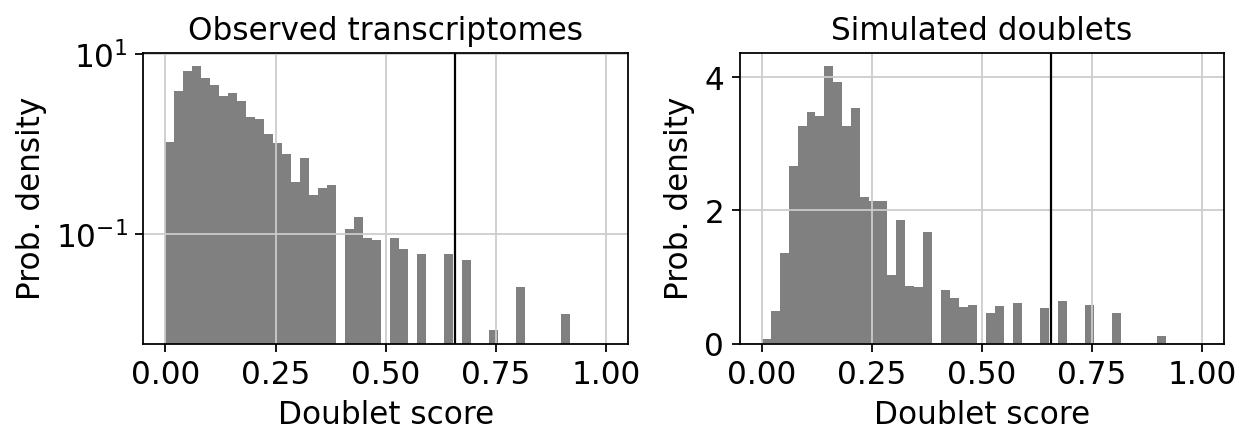

In [28]:
for sample in names:
    #scrub.call_doublets(threshold=0.4)
    #assert scrub.predicted_doublets_ == None
    predicted_doublet_mask = scrub.call_doublets(threshold=0.4)

    cells_of_interest = adata_BS.obs.loc[adata_BS.obs["IDs"] == sample, :].index
    
    adata_i = adata_BS[cells_of_interest, :]


    scrub = scr.Scrublet(adata_i.X)#, expected_doublet_rate=0.06) #**
    
    #doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85,n_prin_comps=30)
        
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    
    scrub.plot_histogram();
    
    print('Running UMAP..')
        
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
        
    print('Done.')
        
    #scrub.plot_embedding('UMAP', order_points=True);
    #doublet_score= pd.DataFrame({'doublet_scores' :list(doublet_scores),'predicted_doublets': list(predicted_doublets)})
    
    adata_i.obs['doublet_score']=scrub.doublet_scores_obs_
    adata_i.uns['sim_doublet_score']=scrub.doublet_scores_sim_
        
    adata_i.obs[['doublet_score']].to_csv('../Files/'+ sample + "_Scrub.csv")
    
    continue
    

# rest of the samples

In [11]:
names=['JB21115', 'JB21116','JB21117', 'JB21118', 'JB21119', 'JB21120']

# Run scrublet through the 6 samples (per sample):
#as recommanded here: #https://github.com/AllonKleinLab/scrublet

/home/nehard/anaconda3/envs/scanpy1_6/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.26
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 43.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 7.6%
Elapsed time: 10.6 seconds
Running UMAP..


Trying to set attribute `.obs` of view, copying.


Done.


/home/nehard/anaconda3/envs/scanpy1_6/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 42.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.1%
Elapsed time: 5.4 seconds
Running UMAP..


Trying to set attribute `.obs` of view, copying.


Done.


/home/nehard/anaconda3/envs/scanpy1_6/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.26
Detected doublet rate = 3.7%
Estimated detectable doublet fraction = 48.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 7.6%
Elapsed time: 12.3 seconds
Running UMAP..


Trying to set attribute `.obs` of view, copying.


Done.


/home/nehard/anaconda3/envs/scanpy1_6/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 33.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.0%
Elapsed time: 9.5 seconds
Running UMAP..


Trying to set attribute `.obs` of view, copying.


Done.


/home/nehard/anaconda3/envs/scanpy1_6/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.27
Detected doublet rate = 3.2%
Estimated detectable doublet fraction = 45.7%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.9%
Elapsed time: 11.9 seconds
Running UMAP..


Trying to set attribute `.obs` of view, copying.


Done.


/home/nehard/anaconda3/envs/scanpy1_6/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 36.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 5.9%
Elapsed time: 9.6 seconds
Running UMAP..


Trying to set attribute `.obs` of view, copying.


Done.


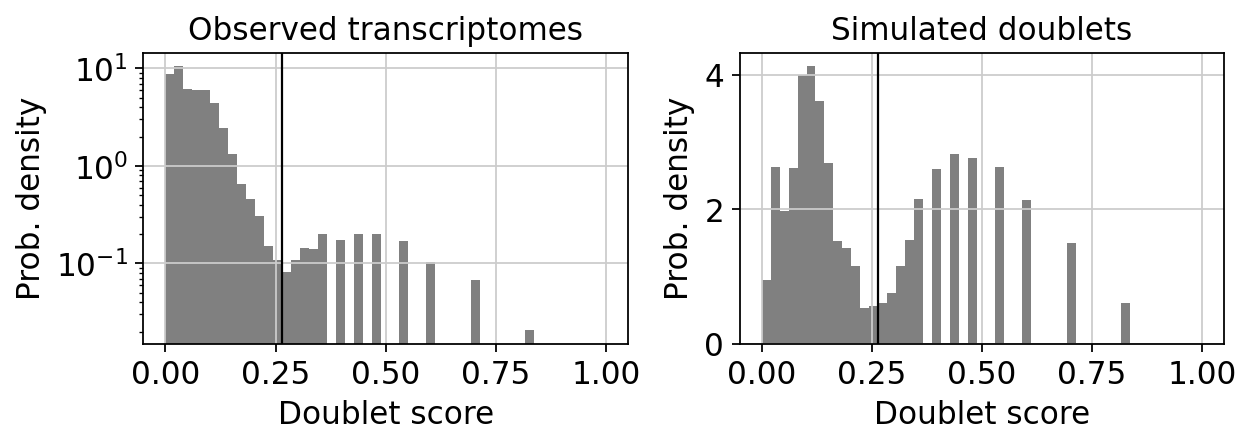

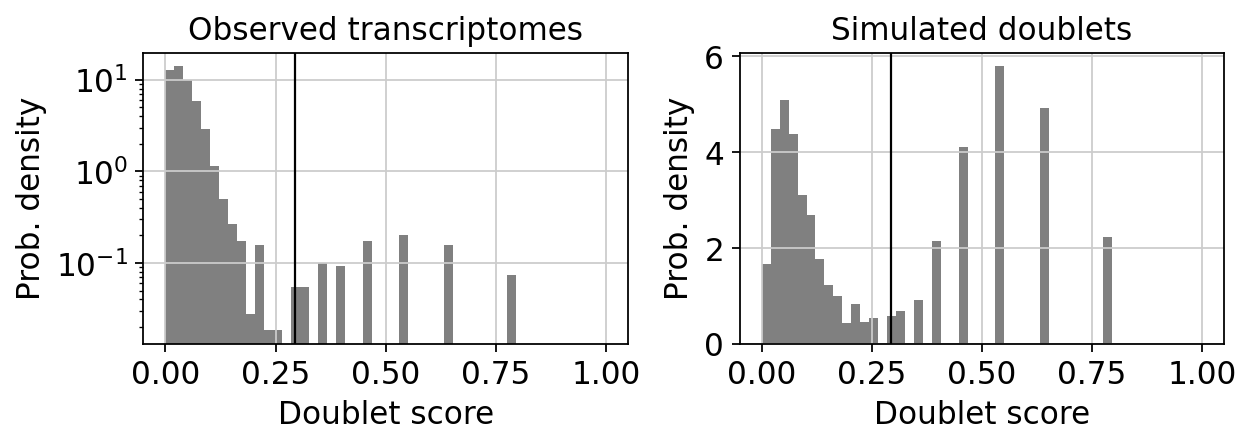

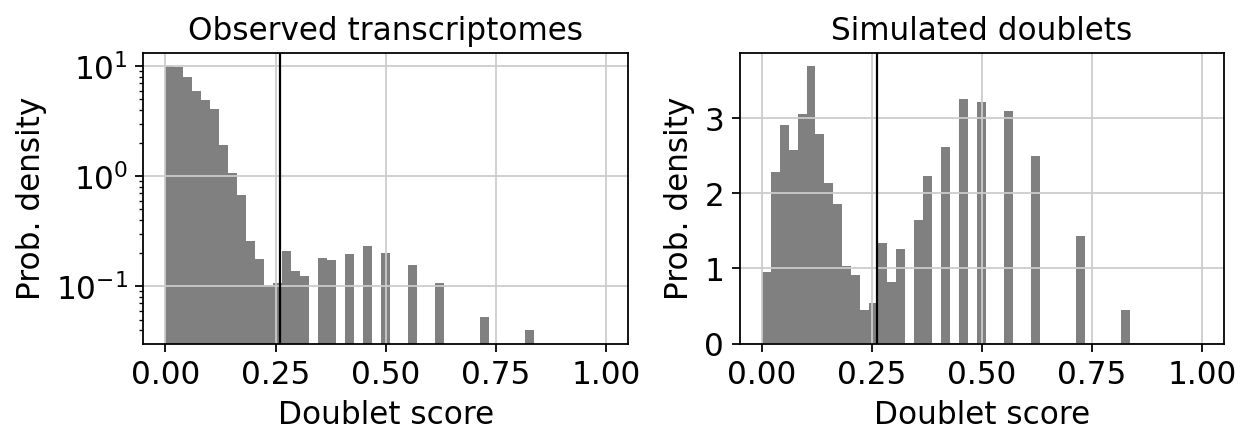

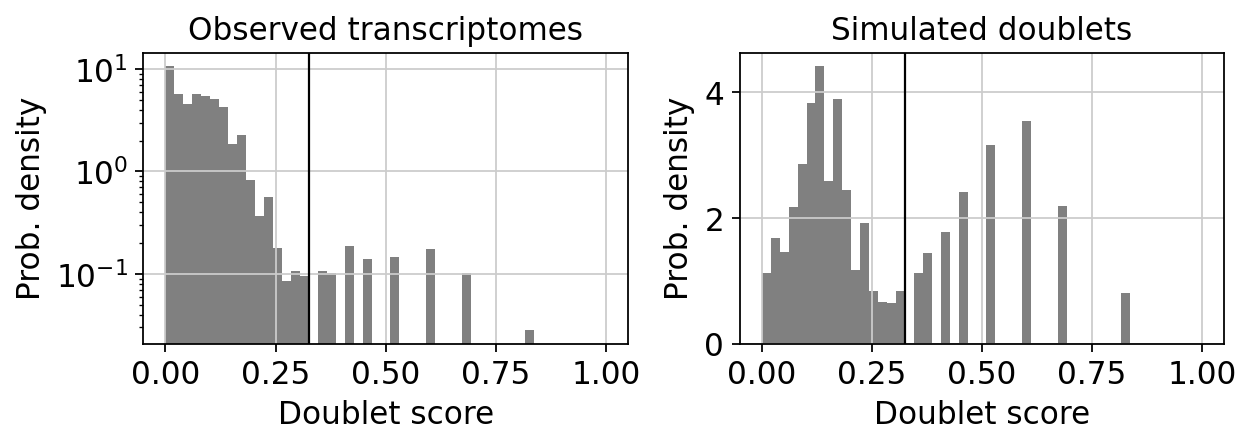

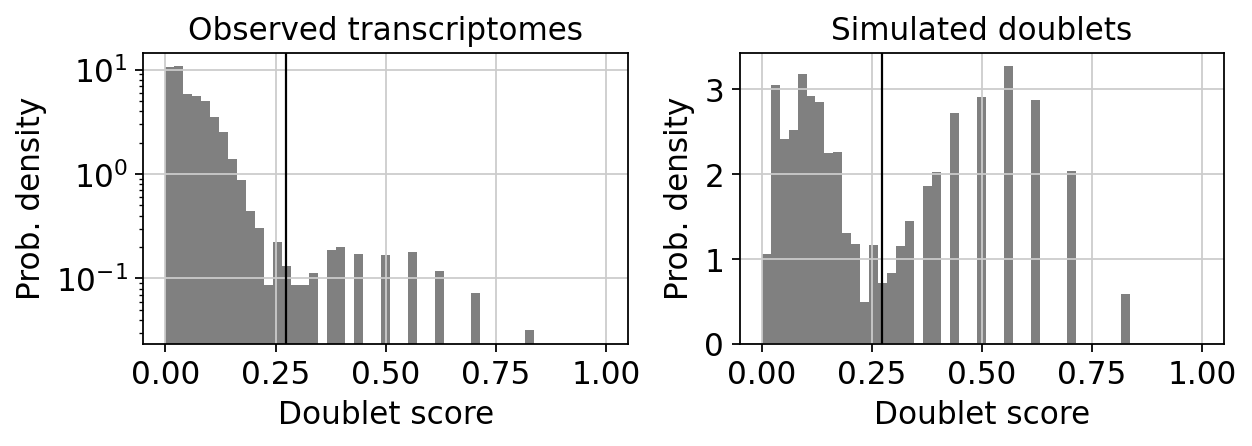

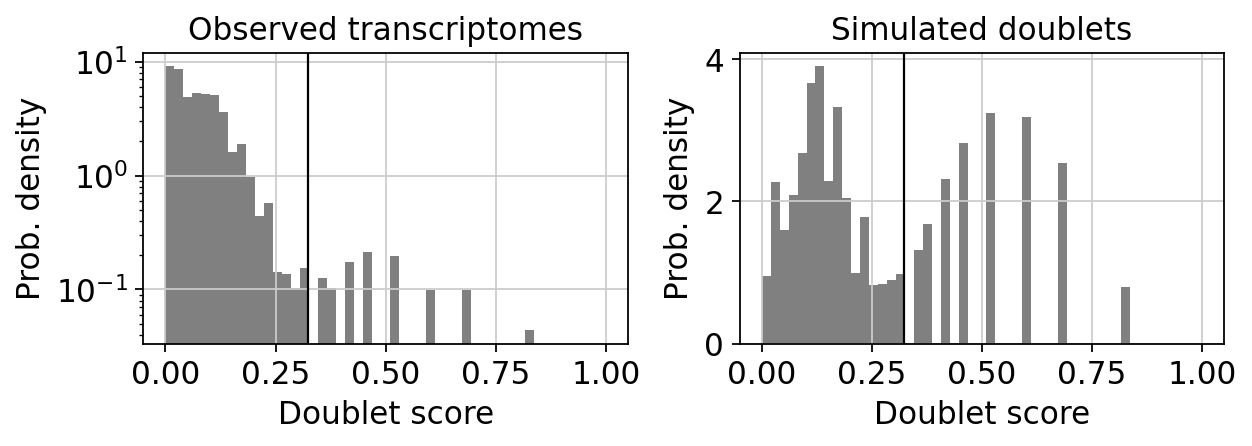

In [12]:
for sample in names:
    
    cells_of_interest = adata_BS.obs.loc[adata_BS.obs["IDs"] == sample, :].index
    
    adata_i = adata_BS[cells_of_interest, :]
    
    scrub = scr.Scrublet(adata_i.X, expected_doublet_rate=0.06) #**
    
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)
    scrub.plot_histogram();
    
    print('Running UMAP..')
        
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
        
    print('Done.')
        
    #scrub.plot_embedding('UMAP', order_points=True);
    
    #doublet_score= pd.DataFrame({'doublet_scores' :list(doublet_scores),'predicted_doublets': list(predicted_doublets)})
        
    adata_i.obs['doublet_score']=scrub.doublet_scores_obs_
    adata_i.uns['sim_doublet_score']=scrub.doublet_scores_sim_
        
    adata_i.obs[['doublet_score']].to_csv('../Files/'+ sample + "_Scrub.csv")
    
    continue
    

# Aggregate scrublet output .csv files

In [29]:
import re

In [30]:
import glob

path = r'../Files/' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)


In [31]:
frame['index']=frame['Unnamed: 0']

In [32]:
frame.head()

,Unnamed: 0,doublet_score,index
0,AAACCCAAGCACTTTG-33,0.102319,AAACCCAAGCACTTTG-33
1,AAACCCAAGTTCCGGC-33,0.098247,AAACCCAAGTTCCGGC-33
2,AAACCCACAAAGGCTG-33,0.106653,AAACCCACAAAGGCTG-33
3,AAACCCACAAGGTCAG-33,0.030005,AAACCCACAAGGTCAG-33
4,AAACCCACAGACAAGC-33,0.067887,AAACCCACAGACAAGC-33


In [33]:
frame.to_csv("../Files/comb_csv_pCov40.csv", index=False) 

In [28]:
Scru = pd.read_csv("../Files/comb_csv_pCov40.csv",header=0)

In [29]:
Scru.head(5)

,Unnamed: 0,doublet_score,index
0,AAACCCAAGCACTTTG-33,0.102319,AAACCCAAGCACTTTG-33
1,AAACCCAAGTTCCGGC-33,0.098247,AAACCCAAGTTCCGGC-33
2,AAACCCACAAAGGCTG-33,0.106653,AAACCCACAAAGGCTG-33
3,AAACCCACAAGGTCAG-33,0.030005,AAACCCACAAGGTCAG-33
4,AAACCCACAGACAAGC-33,0.067887,AAACCCACAGACAAGC-33


In [30]:
Scru = Scru.set_index('index')
Scru.head(5)

,Unnamed: 0,doublet_score
index,,
AAACCCAAGCACTTTG-33,AAACCCAAGCACTTTG-33,0.102319
AAACCCAAGTTCCGGC-33,AAACCCAAGTTCCGGC-33,0.098247
AAACCCACAAAGGCTG-33,AAACCCACAAAGGCTG-33,0.106653
AAACCCACAAGGTCAG-33,AAACCCACAAGGTCAG-33,0.030005
AAACCCACAGACAAGC-33,AAACCCACAGACAAGC-33,0.067887


In [31]:
Scru.shape

(313076, 2)

In [38]:
adata_BS.obs.shape

(313076, 11)

# Add scrublet doublet score to adata object


In [39]:
adata_BS.obs['doublet_score']=Scru.doublet_score

In [40]:
adata_BS.obs.head(5)

,Cells,Samples,IDs,Names,Fig_ids,Groups,Ethnicity,Age_Months,runs_10X,Year,Patient_groups,doublet_score
AAACCCAAGAACTGAT-1,AAACCCAAGAACTGAT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC,0.172450
AAACCCAAGCGGGTTA-1,AAACCCAAGCGGGTTA-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC,0.041903
AAACCCAAGTGTAGAT-1,AAACCCAAGTGTAGAT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC,0.037089
AAACCCACAACAAAGT-1,AAACCCACAACAAAGT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC,0.102319
AAACCCACACGACAGA-1,AAACCCACACGACAGA-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC,0.116209


In [41]:
adata_BS.shape

(313076, 33538)

# Define threshold to be applyed + define doublet vs. singlet


In [42]:
threshold = 0.25
adata_BS.obs['predicted_doublets_1'] = pd.Categorical(['doublet' if x > threshold else 'singlet' for x in adata_BS.obs.doublet_score])

In [43]:
adata_BS.obs.predicted_doublets_1.value_counts()

singlet    300708
doublet     12368
Name: predicted_doublets_1, dtype: int64

In [44]:
cells_of_interest1 = adata_BS.obs.loc[adata_BS.obs["predicted_doublets_1"].isin(["singlet"]), :].index
cells_of_interest1

Index(['AAACCCAAGAACTGAT-1', 'AAACCCAAGCGGGTTA-1', 'AAACCCAAGTGTAGAT-1',
       'AAACCCACAACAAAGT-1', 'AAACCCACACGACAGA-1', 'AAACCCAGTAGACAGC-1',
       'AAACCCAGTATTAAGG-1', 'AAACCCAGTGATACTC-1', 'AAACCCATCAGGTAAA-1',
       'AAACGAAAGACATAAC-1',
       ...
       'TTTGGTTCATAAGCGG-40', 'TTTGGTTCATACGCAT-40', 'TTTGGTTGTATACAGA-40',
       'TTTGGTTGTGATTCTG-40', 'TTTGGTTTCATCGTAG-40', 'TTTGTTGAGCGTTCCG-40',
       'TTTGTTGAGCTGACAG-40', 'TTTGTTGCAGACATCT-40', 'TTTGTTGGTTCCACGG-40',
       'TTTGTTGTCTTGGGCG-40'],
      dtype='object', length=300708)

# Object after doublet removal


In [45]:
#---- object after removing doublets 

adata_Scrub=adata_BS[cells_of_interest1, :]
adata_Scrub

/home/nehard/anaconda3/envs/Hnunu/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 300708 × 33538
    obs: 'Cells', 'Samples', 'IDs', 'Names', 'Fig_ids', 'Groups', 'Ethnicity', 'Age_Months', 'runs_10X', 'Year', 'Patient_groups', 'doublet_score', 'predicted_doublets_1'
    var: 'gene_ids', 'feature_types'

In [46]:
adata_Scrub.obs.head()

,Cells,Samples,IDs,Names,Fig_ids,Groups,Ethnicity,Age_Months,runs_10X,Year,Patient_groups,doublet_score,predicted_doublets_1
AAACCCAAGAACTGAT-1,AAACCCAAGAACTGAT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC,0.172450,singlet
AAACCCAAGCGGGTTA-1,AAACCCAAGCGGGTTA-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC,0.041903,singlet
AAACCCAAGTGTAGAT-1,AAACCCAAGTGTAGAT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC,0.037089,singlet
AAACCCACAACAAAGT-1,AAACCCACAACAAAGT-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC,0.102319,singlet
AAACCCACACGACAGA-1,AAACCCACACGACAGA-1,1,JB19050,HPIR_021_1,pHC1,pHC,W,2.17,B1,2020,pHC,0.116209,singlet


# Save objects

In [47]:
#----------------------------------- Save H5AD + META objects ------------------ #

# after scrublet 
adata_Scrub.write('../H5AD/pCov40_AS_BF_04132021.h5ad')

# AS before filtration 
adata_Scrub.obs.to_csv('../Meta/Meta_pCov40_AS_BF_04132021.csv')


/home/nehard/anaconda3/envs/Hnunu/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [48]:
adata_Scrub

View of AnnData object with n_obs × n_vars = 300708 × 33538
    obs: 'Cells', 'Samples', 'IDs', 'Names', 'Fig_ids', 'Groups', 'Ethnicity', 'Age_Months', 'runs_10X', 'Year', 'Patient_groups', 'doublet_score', 'predicted_doublets_1'
    var: 'gene_ids', 'feature_types'

In [49]:
adata_BS.obs.IDs.value_counts(sort=True)

JB21101    14061
JB19057    13257
JB21114    11416
JB21117    11060
JB21103    10837
JB21119    10760
JB19053    10241
JB21097     9610
JB20076     9596
JB21115     9495
JB21104     9453
JB21102     8979
JB21120     8947
JB21118     8703
JB20067     8565
JB20136     8143
JB19056     7931
JB21100     7901
JB20143     7625
JB21113     7092
JB20078     7065
JB20080     7036
JB19050     6921
JB20068     6913
JB20138     6733
JB20120     6710
JB21098     6630
JB20137     6564
JB20079     6430
JB20077     6398
JB20127     6168
JB20064     5797
JB20066     5581
JB19069     5523
JB21099     5425
JB21116     5324
JB20121     5228
JB19058     5151
JB19066     4475
JB20065     3332
Name: IDs, dtype: int64

In [50]:
adata_Scrub.obs.IDs.value_counts(sort=True)

JB21101    13560
JB19057    12814
JB21117    10629
JB21103    10475
JB21114    10450
JB21119    10395
JB19053     9891
JB21097     9340
JB21115     9161
JB21104     9122
JB21102     8750
JB21120     8656
JB20076     8642
JB21118     8445
JB20067     8229
JB20136     7937
JB21100     7725
JB19056     7640
JB20143     7279
JB21113     6918
JB19050     6686
JB20080     6586
JB20068     6551
JB20138     6534
JB21098     6504
JB20078     6482
JB20120     6466
JB20137     6311
JB20079     6144
JB20077     6134
JB20127     5999
JB20064     5579
JB20066     5386
JB19069     5361
JB21099     5306
JB21116     5223
JB20121     5066
JB19058     4930
JB19066     4239
JB20065     3163
Name: IDs, dtype: int64